## Motif Calling

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
# Changing directory to where everything is stored
reads_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\cycle_dataset\basecalled_short_reads_final.pkl"
dataset_path = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\cycle_dataset\short_read_dataset.pkl"

reads = pd.read_pickle(reads_path)
dataset = pd.read_pickle(dataset_path)

In [2]:
def read_fasta_data_labels(fasta_filepath, labels_filepath):

    with open(fasta_filepath, "r") as f:
        fasta_data = f.read()

    fasta_seq = fasta_data.split("\n")[1]

    with open(labels_filepath, "r") as f:
        labels_data = f.read().split("\n")

    motif_choices = eval(labels_data[0])
    spacer = labels_data[1]
    fp = labels_data[2]
    rp = labels_data[3]
    motif_dataset = eval(labels_data[4])
    fasta_seq_ = labels_data[5]

    assert fasta_seq == fasta_seq_

    return fasta_seq, motif_dataset, motif_choices, spacer, fp, rp


fasta_filepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\cycle_dataset\final_dataset.fasta"
labels_filepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\cycle_dataset\final_dataset_labels.txt"
fasta_seq, motif_dataset, motif_choices, spacer, fp, rp = read_fasta_data_labels(fasta_filepath, labels_filepath)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=42)

In [4]:
dataset = X_test

In [5]:

dataset_read_ids = dataset['read_id'].to_numpy().tolist()
dataset_bases = dataset['Bases'].to_numpy().tolist()
dataset_motifs = dataset['Motifs'].to_numpy().tolist()

#X_train, X_test, y_train, y_test = train_test_split(dataset_read_ids, dataset_bases, test_size=0.2, random_state=42)

reads_read_ids = reads['read_id'].to_numpy().tolist()
reads_bases = reads['read'].to_numpy().tolist()

In [6]:
dataset_dict = {}
for i in range(len(dataset_read_ids)):
    dataset_dict[dataset_read_ids[i]] = (dataset_bases[i], dataset_motifs[i])

reads_dict = {}
for i in range(len(reads_read_ids)):
    reads_dict[reads_read_ids[i]] = reads_bases[i]


In [7]:
def motif_search(read, motif):
    return read.count(motif)

def get_motif_counts(read_motifs):
    motif_counts = np.zeros(13, dtype=int)
    for motif in read_motifs:
        motif_counts[motif-1] += 1
    return motif_counts


from tqdm.notebook import tqdm
motif_set = [spacer, fp, rp] + motif_choices

def motifs_identified_per_read():

    correct_motifs_identified_arr = []
    motif_acc_arr = []

    for read_id in dataset_read_ids:
        # Pick a read to analyze
        read = reads_dict[read_id]
        # Get the dataset bases for the read
        dataset_bases = dataset_dict[read_id][0]
        dataset_motifs = dataset_dict[read_id][1]

        # Check how many of the motifs are present in the read
        motif_counts_per_read = np.zeros(13, dtype=int)
        for i, motif in enumerate(motif_set):
            motif_counts_per_read[i] =  motif_search(read, motif)
        dataset_motif_counts = get_motif_counts(dataset_motifs)

        correct_motifs_identified = [i if i<=j else j for i,j in zip(motif_counts_per_read, dataset_motif_counts)]

        correct_motifs_identified_arr.append(sum(correct_motifs_identified))
        motif_acc_arr.append(sum(correct_motifs_identified)/sum(dataset_motif_counts))


    return correct_motifs_identified_arr, motif_acc_arr
        

In [8]:
correct_motifs_identified_arr, motif_acc_arr = motifs_identified_per_read()
selected_reads = [i for i in motif_acc_arr if i > 0]
selected_reads_counts = [i for i in correct_motifs_identified_arr if i > 0]
print(np.mean(selected_reads))
print(np.mean(selected_reads_counts))

0.5794395855453063
21.10518292682927


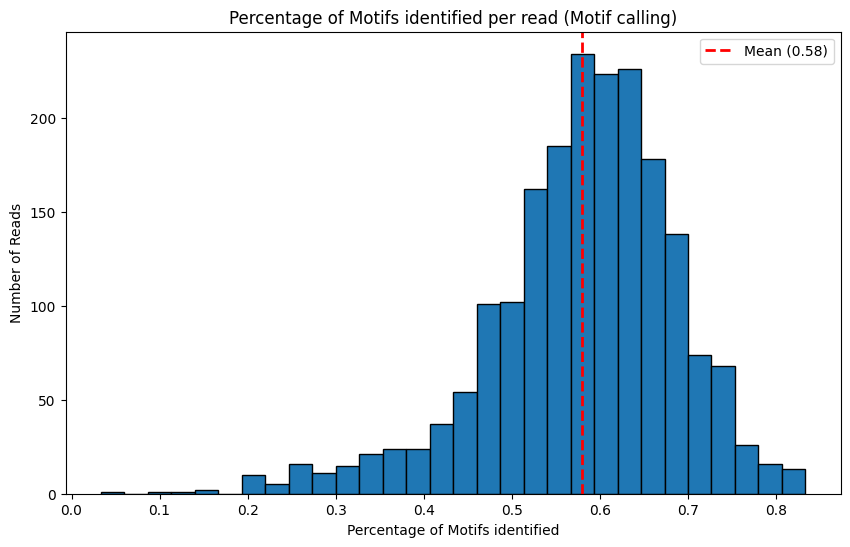

In [9]:
accuracies = selected_reads
# Calculate mean and median
mean_accuracy = np.mean(accuracies)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(accuracies, bins=30, edgecolor='black')

# Add mean and median lines
plt.axvline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label=f'Mean ({mean_accuracy:.2f})')

# Customize the plot
plt.title('Percentage of Motifs identified per read (Motif calling)')
plt.xlabel('Percentage of Motifs identified')
plt.ylabel('Number of Reads')
plt.legend()

# Show the plot
plt.show()

In [10]:

import torchaudio
from rapidfuzz.distance import Levenshtein

motif_set = [spacer, fp, rp] + motif_choices
motifs_missed = np.zeros(13, dtype=int)

def get_evaluation_metrics():

    correct_motifs_identified_arr = []
    motif_acc_arr = []
    motifs_missed = np.zeros(13, dtype=int).tolist()
    total_motifs = np.zeros(13, dtype=int).tolist()
    read_distances = []

    for read_id in dataset_read_ids:
        # Pick a read to analyze
        read = reads_dict[read_id]
        # Get the dataset bases for the read
        dataset_bases = dataset_dict[read_id][0]
        dataset_motifs = dataset_dict[read_id][1]

        # Check how many of the motifs are present in the read
        motif_counts_per_read = np.zeros(13, dtype=int)
        for i, motif in enumerate(motif_set):
            motif_counts_per_read[i] =  motif_search(read, motif)
        dataset_motif_counts = get_motif_counts(dataset_motifs)

        # this is just wrong since we are zipping
        motifs_missed = [
            i + (k - j) for i, j, k in zip(
                motifs_missed, motif_counts_per_read, 
                dataset_motif_counts
            )
        ]
        total_motifs = [i + j for i, j in zip(total_motifs, dataset_motif_counts)]
        correct_motifs_identified = [i if i<=j else j for i,j in zip(motif_counts_per_read, dataset_motif_counts)]

        correct_motifs_identified_arr.append(sum(correct_motifs_identified))
        motif_acc_arr.append(sum(correct_motifs_identified)/sum(dataset_motif_counts))

        
        read_distances.append(
            Levenshtein.distance(read, dataset_bases) / len(dataset_bases))
        
    return correct_motifs_identified_arr, motif_acc_arr, motifs_missed,  read_distances, total_motifs

In [11]:
correct_motifs_identified_arr, motif_acc_arr, motifs_missed,  read_distances, total_motifs = get_evaluation_metrics()

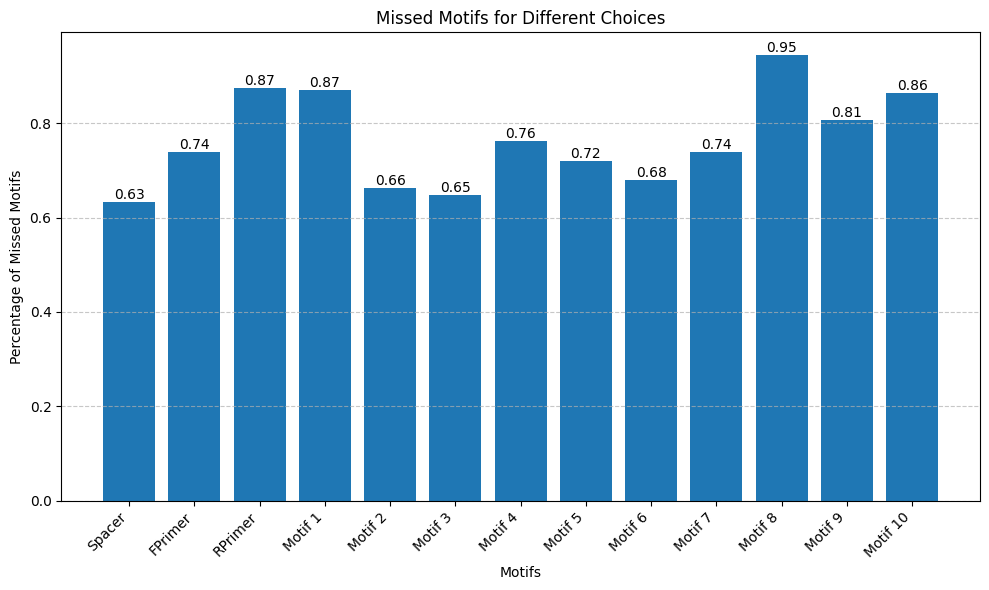

In [12]:
motif_labels = ["Spacer", "FPrimer", "RPrimer"] + [f"Motif {i+1}" for i in range(10)]
missed_percentage = [i/j for i, j in zip(motifs_missed, total_motifs)]
motifs = motif_labels

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(motifs, missed_percentage)

# Customize the chart
plt.title('Missed Motifs for Different Choices')
plt.xlabel('Motifs')
plt.ylabel('Percentage of Missed Motifs')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels if they overlap
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


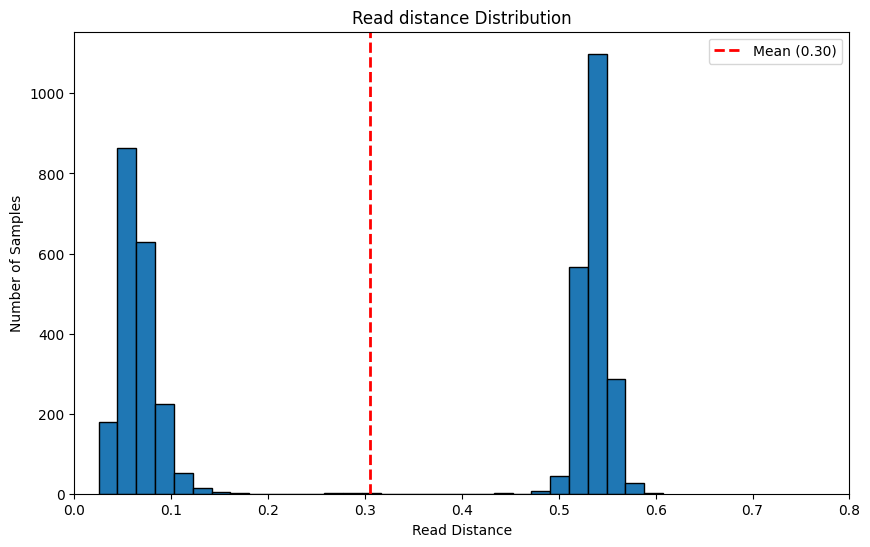

In [13]:
accuracies = read_distances
# Calculate mean and median
mean_accuracy = np.mean(accuracies)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(accuracies, bins=30, edgecolor='black')

# Add mean and median lines
plt.axvline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label=f'Mean ({mean_accuracy:.2f})')
plt.xlim(0,0.8)
# Customize the plot
plt.title('Read distance Distribution')
plt.xlabel('Read Distance')
plt.ylabel('Number of Samples')
plt.legend()

# Show the plot
plt.show()

## Alignment Metric

In [14]:
def construct_cycle(motif_positions, motif_set):

    cycle_key = {}

    for i, positions in enumerate(motif_positions):
        for j in positions:
            cycle_key[j] = i+1

    # sort the cycle key
    cycle_key = dict(sorted(cycle_key.items()))
     
    # get the cycle
    cycle = [cycle_key[i] for i in cycle_key.keys()]
    return cycle

def get_motifs_in_cycle_position(read, motif_set):

    # See which motif is present and then find its starting location
    motif_counts = np.zeros(13, dtype=int)
    motif_positions = [[] for i in range(13)]

    for i, motif in enumerate(motif_set):
        counts = motif_search(read, motif)
        motif_positions[i] = [j for j in range(len(read)) if read.startswith(motif, j)]
        motif_counts[i] = motif_search(read, motif)

    cycle = construct_cycle(motif_positions, motif_set)
    
    return motif_counts, motif_positions, cycle

In [15]:
## For each read see sequence of motifs found and compare

def get_read_distances_motif_level():
   
    distances_arr_motif_level = []

    for read_id in dataset_read_ids:
        # Pick a read to analyze
        read = reads_dict[read_id]
        # Get the dataset bases for the read
        dataset_bases = dataset_dict[read_id][0]
        dataset_motifs = dataset_dict[read_id][1]

        # Check how many of the motifs are present in the read
        motif_counts, motif_positions, cycle = get_motifs_in_cycle_position(read, motif_set)
        
        # Get read distance between the two
        motif_transcript = " ".join([motif for motif in dataset_motifs])
        read_transcript = " ".join([str(i) for i in cycle])

        distances_arr_motif_level.append(Levenshtein.distance(motif_transcript, read_transcript) / len(motif_transcript))

    return distances_arr_motif_level

In [16]:
def calculate_error_rates(ground_truth, prediction):
    insertions = 0
    deletions = 0
    substitutions = 0
    
    i, j = 0, 0
    while i < len(ground_truth) and j < len(prediction):
        if ground_truth[i] == prediction[j]:
            i += 1
            j += 1
        elif j + 1 < len(prediction) and ground_truth[i] == prediction[j + 1]:
            # Insertion
            insertions += 1
            j += 1
        elif i + 1 < len(ground_truth) and ground_truth[i + 1] == prediction[j]:
            # Deletion
            deletions += 1
            i += 1
        else:
            # Substitution
            substitutions += 1
            i += 1
            j += 1
    
    # Count remaining insertions or deletions
    insertions += len(prediction) - j
    deletions += len(ground_truth) - i
    
    total_length = len(ground_truth)
    
    return {
        "insertion_rate": insertions / total_length,
        "deletion_rate": deletions / total_length,
        "substitution_rate": substitutions / total_length,
        "total_error_rate": (insertions + deletions + substitutions) / total_length
    }

In [17]:
counter = 0
insertion_rates = []
subsitution_rates = []
deletion_rates = []
total_alignment_error_rates = []
for i, j in zip(constructed_cycles, actual_cycles):

    prediction_motifs = [t for t in i if not (t == 1 or t==2 or t==3)]
    target_motifs = [t for t in j if not (t == 1 or t==2 or t==3)]
    
    error_rates = calculate_error_rates(target_motifs, prediction_motifs)

    insertion_rates.append(error_rates['insertion_rate'])
    subsitution_rates.append(error_rates['substitution_rate'])
    deletion_rates.append(error_rates['deletion_rate'])
    total_alignment_error_rates.append(error_rates['total_error_rate'])
 

<BarContainer object of 2 artists>

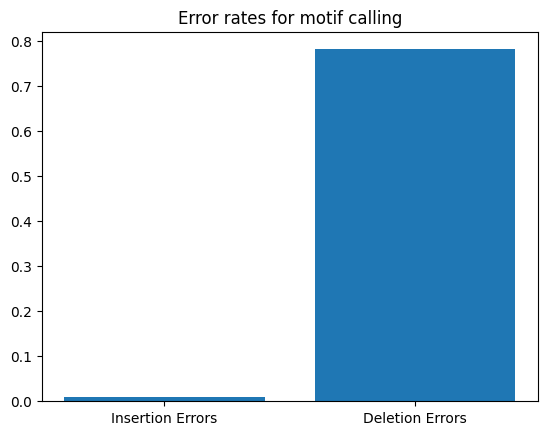

In [18]:
columns = ['Insertion Errors', 'Deletion Errors']
rates = [np.mean(insertion_rates), np.mean(deletion_rates)]

plt.title("Error rates for motif calling")
plt.bar(columns, rates)

## Pure information metric

In [19]:
def get_percentage_of_bases_aligned(ground_truth, prediction):
    aligned_bases = 0
    for i in range(len(ground_truth) and len(prediction)):
        if ground_truth[i] == prediction[i]:
            aligned_bases += 1
    return aligned_bases / len(ground_truth)

aligned_bases = []

for read_id in dataset_read_ids:
    # Pick a read to analyze
    read = reads_dict[read_id]
    # Get the dataset bases for the read
    dataset_bases = dataset_dict[read_id][0]
    dataset_motifs = dataset_dict[read_id][1]
    
    try:
        aligned = get_percentage_of_bases_aligned(dataset_bases, read)
        aligned_bases.append(aligned)
    except:
        continue

    print(aligned)

0.24078624078624078
0.2584856396866841
0.2911010558069382
0.2943722943722944
0.19029850746268656
0.22170900692840648
0.2777777777777778
0.2538293216630197
0.20608108108108109
0.21837088388214904
0.2669683257918552
0.2616279069767442
0.24236252545824846
0.1673469387755102
0.22857142857142856
0.23703703703703705
0.2074688796680498
0.25
0.2394736842105263
0.20695652173913043
0.2404255319148936
0.24204702627939143
0.23426573426573427
0.2339622641509434
0.26776649746192893
0.28079242032730406
0.21700223713646533
0.24754901960784315
0.2512396694214876
0.2422907488986784
0.23046875
0.2523148148148148
0.27669172932330827
0.24285714285714285
0.21020408163265306
0.20952380952380953
0.2562814070351759
0.2401129943502825
0.32320441988950277
0.24412094064949608
0.2440944881889764
0.27199074074074076
0.213653603034134
0.24063400576368876
0.24358974358974358
0.23125
0.25735294117647056
0.2832579185520362
0.2610062893081761
0.24369747899159663
0.22427440633245382
0.21380243572395127
0.4249547920433996

## Motif Caller

In [20]:

import torch
import torch.nn as nn
import torch.optim as optim
from crnn import CNN_BiGRU_Classifier
import math
from tqdm.notebook import tqdm
import numpy as np
from training_data import data_preproc, load_pre_data
from sklearn.model_selection import train_test_split
from greedy_decoder import GreedyCTCDecoder, beam_search_decoder
from utils import get_actual_transcript, get_model_savepath, get_motifs_identified
import torchaudio
import datetime

# Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

X,y = data_preproc(chop_reads=1)
print(f"Number of samples: {len(X)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"Running on {device}")

labels_int = np.arange(14).tolist()
labels = [f"{i}" for i in labels_int] # Tokens to be fed into greedy decoder
greedy_decoder = GreedyCTCDecoder(labels=labels)

model_save_path = get_model_savepath()
model_save_iterations = 200

# Model Parameters
input_size = 1  # Number of input channels
hidden_size = 128
num_layers = 4
output_size = 14  # Number of output classes
dropout_rate = 0.2

saved_model = True

# Model Definition
model = CNN_BiGRU_Classifier(input_size, hidden_size, num_layers, output_size, dropout_rate)

if saved_model:
    model_path = "models\model.pth"

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
ctc_loss = nn.CTCLoss(zero_infinity=True)

presaved = False

"""
if presaved:
    X, y = load_pre_data()
else:
    X,y = data_preproc()
"""
    
# Creating Train, Test, Validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

torch.autograd.set_detect_anomaly(True)

n_classes = 14
step_sequence = 100
window_overlap = 50
length_per_sample = 150
model_output_split_size = 1

epochs = 2

<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Parv\AppData\Local\Temp\ipykernel_21116\1065134263.py:46: SyntaxWarning: invalid escape sequence '\m'
  model_path = "models\model.pth"
100%|██████████| 20000/20000 [00:26<00:00, 763.50it/s]


Number of samples: 20000
Running on cuda


In [21]:



# Test Loop
model.eval()
test_loss = 0.0
distances_arr = []
motifs_identifed_arr = []
greedy_transcripts = []
actual_transcripts = []
with torch.no_grad():
    for i in tqdm(range(len(X_test))):

        test_sequence, target_sequence = torch.tensor(X_test[i]).to(device), torch.tensor(y_test[i]).to(device)

        model_output_timestep = model(test_sequence) # Getting model output

        input_lengths = torch.tensor(X_test[i].shape[0])
        target_lengths = torch.tensor(len(target_sequence))

        loss = ctc_loss(model_output_timestep, target_sequence, input_lengths, target_lengths)
        test_loss += loss.item()

        greedy_result = greedy_decoder(model_output_timestep)
        greedy_transcript = " ".join(greedy_result)
        actual_transcript = get_actual_transcript(target_sequence)
        greedy_transcripts.append(greedy_transcript)
        actual_transcripts.append(actual_transcript)


        motif_err = torchaudio.functional.edit_distance(actual_transcript, greedy_transcript) / len(actual_transcript)
        distances_arr.append(motif_err)

        motifs_identifed = get_motifs_identified(actual_transcript, greedy_transcript)
        motifs_identifed_arr.append(motifs_identifed)


test_loss /= len(X_test)
test_accuracy = np.mean(distances_arr)
motifs_identifed = np.mean(motifs_identifed_arr)
print(f"Test Loss: {test_loss:.4f}, Test Edit Distance: {test_accuracy:.4f}, Motifs Identified: {motifs_identifed:.4f}")


  0%|          | 0/4000 [00:00<?, ?it/s]

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\utils\_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Test Loss: 1.4008, Test Edit Distance: 0.2430, Motifs Identified: 0.7986


In [22]:
motif_caller_distances = distances_arr.copy()
motif_caller_motifs_identified = motifs_identifed_arr.copy()
motif_caller_transcripts = greedy_transcripts.copy()
actual_transcripts = actual_transcripts.copy()

In [23]:
np.save('motif_caller_transcripts.npy', motif_caller_transcripts)
np.save('actual_transcripts.npy', actual_transcripts)

In [24]:
import numpy as np

def smith_waterman(seq1, seq2, match_score=2, mismatch_score=-1, gap_penalty=-2):
    # Initialize the scoring matrix
    rows, cols = len(seq1) + 1, len(seq2) + 1
    score_matrix = np.zeros((rows, cols))

    # Fill the scoring matrix
    max_score = 0
    max_pos = None

    for i in range(1, rows):
        for j in range(1, cols):
            match = score_matrix[i-1][j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch_score)
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            score_matrix[i][j] = max(0, match, delete, insert)

            if score_matrix[i][j] > max_score:
                max_score = score_matrix[i][j]
                max_pos = (i, j)

    # Traceback
    aligned_seq1, aligned_seq2 = "", ""
    i, j = max_pos

    while i > 0 and j > 0 and score_matrix[i][j] > 0:
        score = score_matrix[i][j]
        score_diag = score_matrix[i-1][j-1]
        score_up = score_matrix[i-1][j]
        score_left = score_matrix[i][j-1]

        if score == score_diag + (match_score if seq1[i-1] == seq2[j-1] else mismatch_score):
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            i -= 1
            j -= 1
        elif score == score_up + gap_penalty:
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = "-" + aligned_seq2
            i -= 1
        elif score == score_left + gap_penalty:
            aligned_seq1 = "-" + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            j -= 1

    return aligned_seq1, aligned_seq2, max_score

def align_read_to_reference(read, reference):
    best_alignment = None
    best_score = -float('inf')

    # Slide the read along the reference
    for i in range(len(reference) - len(read) + 1):
        ref_segment = reference[i:i+len(read)]
        aligned_read, aligned_ref, score = smith_waterman(read, ref_segment)
        
        if score > best_score:
            best_score = score
            best_alignment = (aligned_read, aligned_ref, i)

    return best_alignment

In [25]:
identity_err = []

for greedy_transcript, actual_transcript in tqdm(zip(motif_caller_transcripts, actual_transcripts)):


    transcript_arr = actual_transcript.strip().split(" ")
    greedy_transcript_arr = greedy_transcript.strip().split(" ")



    dataset_motifs = [int(i) for i in transcript_arr]
    dataset_motifs = [i for i in dataset_motifs if i != 1 and i != 3 and i != 2]    

    greedy_motifs = [int(i) for i in greedy_transcript_arr]
    greedy_motifs = [i for i in greedy_motifs if i != 1 and i != 3 and i != 2]

    transcript_cleaned = " ".join([str(i) for i in dataset_motifs])
    print(transcript_cleaned)
    greedy_transcript_cleaned = " ".join([str(i) for i in greedy_motifs])
    print(greedy_transcript_cleaned)

    try:
        aligned_read, aligned_ref, start_position = align_read_to_reference(greedy_transcript_cleaned, transcript_cleaned)

        print(f"Read aligned at position {start_position}:")
        print(f"Reference: {aligned_ref}")
        print(f"Read:      {aligned_read}")
        identity = sum(1 for a, b in zip(aligned_read, aligned_ref) if a == b) / len(aligned_read)
        print(f"Identity: {identity:.2f}")
        identity_err.append(identity)
    except:
        continue
    
    

' Getting aligned reads\nfor greedy_transcript, actual_transcript in tqdm(zip(motif_caller_transcripts, actual_transcripts)):\n\n\n    transcript_arr = actual_transcript.strip().split(" ")\n    greedy_transcript_arr = greedy_transcript.strip().split(" ")\n\n\n\n    dataset_motifs = [int(i) for i in transcript_arr]\n    dataset_motifs = [i for i in dataset_motifs if i != 1 and i != 3 and i != 2]    \n\n    greedy_motifs = [int(i) for i in greedy_transcript_arr]\n    greedy_motifs = [i for i in greedy_motifs if i != 1 and i != 3 and i != 2]\n\n    transcript_cleaned = " ".join([str(i) for i in dataset_motifs])\n    print(transcript_cleaned)\n    greedy_transcript_cleaned = " ".join([str(i) for i in greedy_motifs])\n    print(greedy_transcript_cleaned)\n\n    try:\n        aligned_read, aligned_ref, start_position = align_read_to_reference(greedy_transcript_cleaned, transcript_cleaned)\n\n        print(f"Read aligned at position {start_position}:")\n        print(f"Reference: {aligned_ref

## Cycles Recovered

(array([1.076e+03, 0.000e+00, 0.000e+00, 1.308e+03, 1.960e+02, 2.040e+02,
        0.000e+00, 5.750e+02, 6.700e+01, 0.000e+00, 8.100e+01, 1.480e+02,
        1.600e+01, 0.000e+00, 0.000e+00, 3.800e+01, 0.000e+00, 2.000e+00,
        3.100e+01, 0.000e+00, 4.000e+00, 4.000e+00, 2.300e+01, 0.000e+00,
        0.000e+00, 2.080e+02, 1.260e+02, 0.000e+00, 0.000e+00, 2.658e+03]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

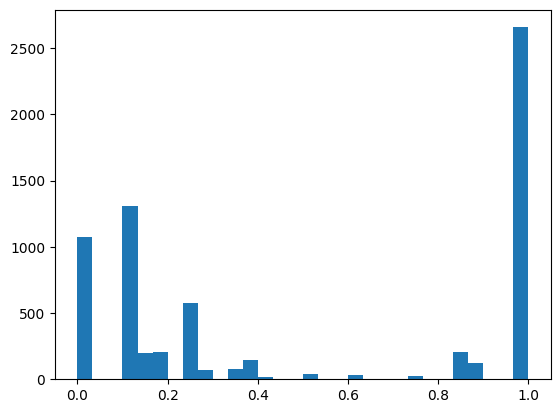

In [74]:
# Cycle from read - cycle starts with fp and ends with rp, check reads for full cycle
from itertools import groupby

counter = 0
cycles_recovered_motif_caller = []
recovered_information_arr_caller = []
total_information_arr_caller = []
for greedy_transcript, actual_transcript in zip(motif_caller_transcripts, actual_transcripts):


    transcript_arr = actual_transcript.strip().split(" ")
    greedy_transcript_arr = greedy_transcript.strip().split(" ")



    dataset_motifs = [int(i) for i in transcript_arr]
    dataset_motifs = [i for i in dataset_motifs if i != 1 and i != 3]
    
    

    greedy_motifs = [int(i) for i in greedy_transcript_arr]
    greedy_motifs = [i for i in greedy_motifs if i != 1 and i != 3]
    

    spl_actual = [list([i for i in y]) for x, y in groupby(dataset_motifs, lambda z: z == 2) if not x]
    spl_greedy = [list([i for i in y]) for x, y in groupby(greedy_motifs, lambda z: z == 2) if not x]

    
   
       
    for i in spl_actual:
        if len(i)>5:
            best_score = 0
            for j in spl_greedy:
                correct_bases = 0
                for x, y in zip(i, j):
                    if x==y:
                        correct_bases += 1
                score = correct_bases/len(i)
                if score > best_score:
                    best_score = score

            total_information_arr_caller.append(len(i))
            recovered_information_arr_caller.append(len(i)*best_score)
            cycles_recovered_motif_caller.append(best_score)
                
    """
    
    print(greedy_motifs)
    print(spl)
    """

# Plot top 50 % of the scores
#cycles_recovered_motif_caller.sort(reverse=True)
#cycles_recovered_motif_caller_top50 = cycles_recovered_motif_caller[:int(len(cycles_recovered_motif_caller)/2)]
#print(np.mean(cycles_recovered_motif_caller_top50))
#plt.hist(cycles_recovered_motif_caller_top50, bins=30)

# Add mean line
plt.hist(cycles_recovered_motif_caller, bins=30)





In [75]:
sum(recovered_information_arr_caller)/sum(total_information_arr_caller)

0.516025206010664

In [70]:

correct_bases_arr = []
total_bases_arr = []
# Repeat the same for motif calling
cycles_recovered_motif_calling = []

for read_id in dataset_read_ids:
    # Pick a read to analyze
    read = reads_dict[read_id]
    dataset_motifs = dataset_dict[read_id][1]
    # Get the dataset bases for the read

    dataset_motifs = [i for i in dataset_motifs if i != 1 and i != 3]

    motif_counts, motif_positions, cycle = get_motifs_in_cycle_position(read, motif_set)

    spl_actual = [list([i for i in y]) for x, y in groupby(dataset_motifs, lambda z: z == 2) if not x]
    spl_greedy = [list([i for i in y]) for x, y in groupby(cycle, lambda z: z == 2) if not x]
    
    for i in spl_actual:
        if len(i)>5:
            best_score = 0
            for j in spl_greedy:
                correct_bases = 0
                for x, y in zip(i, j):
                    if x==y:
                        correct_bases += 1
                score = correct_bases/len(i)
                if score > best_score:
                    best_score = score

            total_bases_arr.append(len(i))
            correct_bases_arr.append(len(i)*best_score)
            cycles_recovered_motif_calling.append(best_score)
    

In [73]:
# get top 10 % of the information recovered and total inofrmation
information_recovered_arr.sort(reverse=True)
total_information_arr.sort(reverse=True)
information_recovered_arr_top10 = information_recovered_arr[:int(len(information_recovered_arr)/10)]
total_information_arr_top10 = total_information_arr[:int(len(total_information_arr)/10)]
print(sum(information_recovered_arr_top10)/sum(total_information_arr_top10))


0.2893860946745562


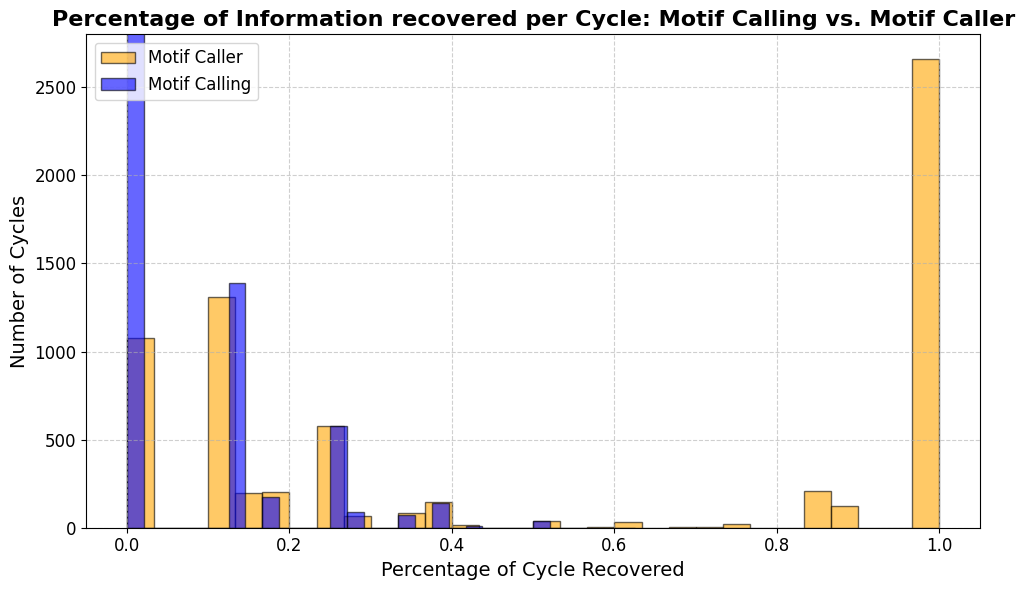

In [28]:
import matplotlib.pyplot as plt

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(cycles_recovered_motif_caller, bins=30, alpha=0.6, edgecolor='black', color='orange', label='Motif Caller')
plt.hist(cycles_recovered_motif_calling, bins=30, alpha=0.6, edgecolor='black', color='blue', label='Motif Calling')

# Add titles and labels
plt.title('Percentage of Information recovered per Cycle: Motif Calling vs. Motif Caller', fontsize=16, fontweight='bold')
plt.xlabel('Percentage of Cycle Recovered', fontsize=14)
plt.ylabel('Number of Cycles', fontsize=14)

# Add a legend
plt.legend(loc='upper left',fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 2800)

# Increase font size for ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()  # Adjust the layout to prevent clipping of labels
plt.show()


In [69]:
# Get top 10% of the scores
sum([i for i in cycles_recovered_motif_caller if i > 0.9])/len(cycles_recovered_motif_caller) * 2

0.7858093126385809

In [76]:
[i for i in cycles_recovered_motif_calling if i>0.8]

[]

## Percentage of motifs identified

In [29]:
# Motif Calling

correct_motifs_identified_arr, motif_acc_arr = motifs_identified_per_read()
selected_reads = [i for i in motif_acc_arr if i > 0]
selected_reads_counts = [i for i in correct_motifs_identified_arr if i > 0]

accuracies_2 = motif_acc_arr

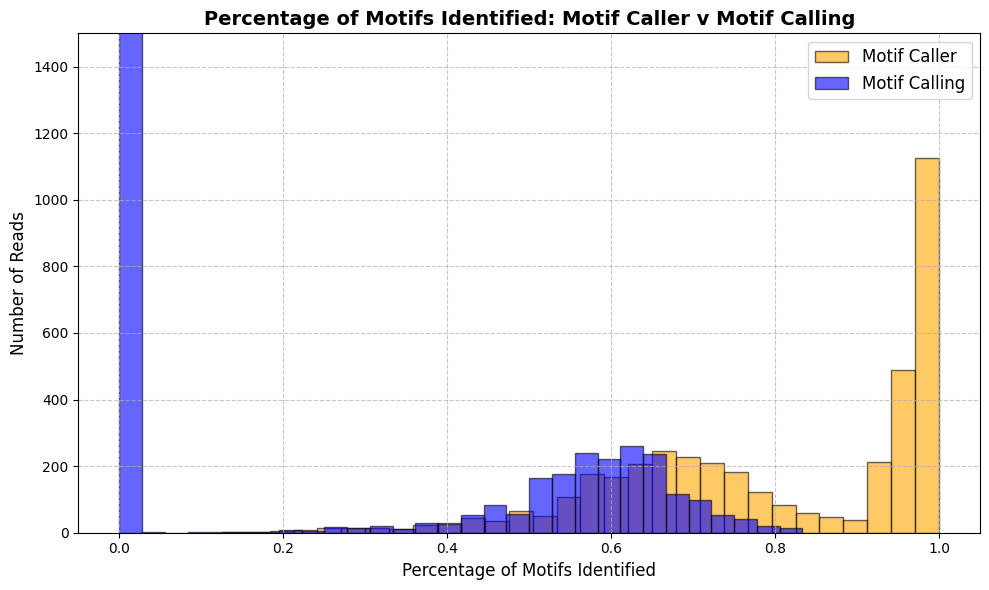

In [30]:
import numpy as np
import matplotlib.pyplot as plt

accuracies = motif_caller_motifs_identified
# Create the figure and axis objects for more control
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first histogram
n1, bins1, patches1 = ax.hist(accuracies, bins=30, alpha=0.6, color='orange', edgecolor='black', label='Motif Caller')

# Plot the second histogram
n2, bins2, patches2 = ax.hist(accuracies_2, bins=30, alpha=0.6, color='blue', edgecolor='black', label='Motif Calling')

# Customize the plot appearance
ax.set_title('Percentage of Motifs Identified: Motif Caller v Motif Calling', fontsize=14, fontweight='bold')
ax.set_xlabel('Percentage of Motifs Identified', fontsize=12)
ax.set_ylabel('Number of Reads', fontsize=12)
ax.legend(loc='upper right', fontsize=12)

# Additional academic-style formatting
ax.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.ylim(0, 1500)
plt.tight_layout()  # Adjust layout for better fit

# Show the plot
plt.show()


## Read distance distribution

In [47]:
## For each read see sequence of motifs found and compare

def get_read_distances_motif_level():
   
    distances_arr_motif_level = []

    for read_id in dataset_read_ids:
        # Pick a read to analyze
        read = reads_dict[read_id]
        # Get the dataset bases for the read
        dataset_bases = dataset_dict[read_id][0]
        dataset_motifs = dataset_dict[read_id][1]

        # Check how many of the motifs are present in the read
        motif_counts, motif_positions, cycle = get_motifs_in_cycle_position(read, motif_set)
        
        # Get read distance between the two
        motif_transcript = " ".join([str(motif) for motif in dataset_motifs])
        read_transcript = " ".join([str(i) for i in cycle])

        distances_arr_motif_level.append(Levenshtein.distance(motif_transcript, read_transcript) / len(motif_transcript))

    return distances_arr_motif_level

In [48]:
# Motif Calling


accuracies_2 = get_read_distances_motif_level()

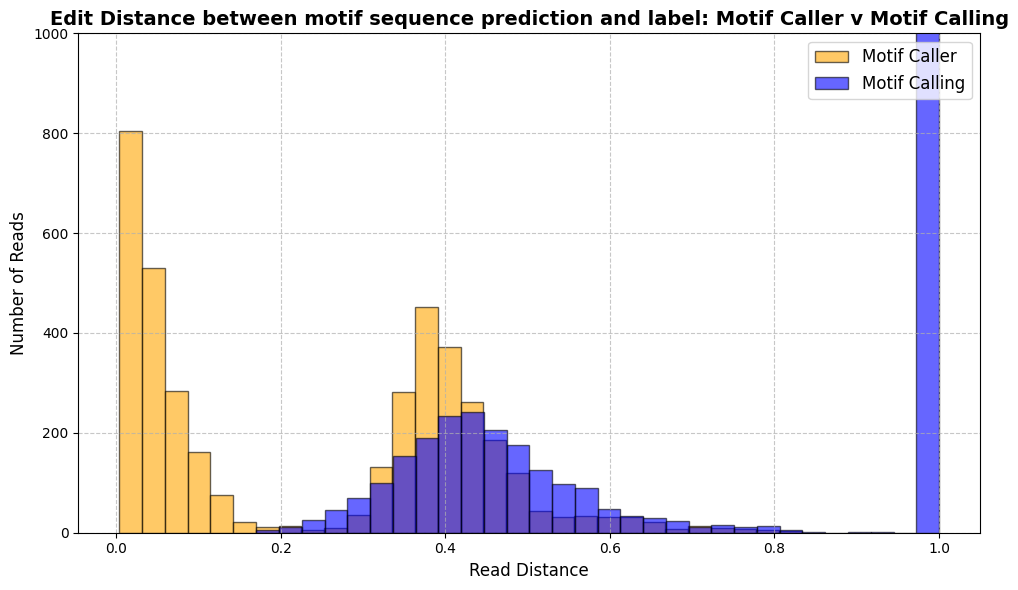

In [49]:

accuracies = motif_caller_distances


# Create the figure and axis objects for more control
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first histogram
n1, bins1, patches1 = ax.hist(accuracies, bins=30, alpha=0.6, color='orange', edgecolor='black', label='Motif Caller')

# Plot the second histogram
n2, bins2, patches2 = ax.hist(accuracies_2, bins=30, alpha=0.6, color='blue', edgecolor='black', label='Motif Calling')


# Customize the plot appearance
ax.set_title('Edit Distance between motif sequence prediction and label: Motif Caller v Motif Calling', fontsize=14, fontweight='bold')
ax.set_xlabel('Read Distance', fontsize=12)
ax.set_ylabel('Number of Reads', fontsize=12)
ax.legend(loc='upper right', fontsize=12)

# Additional academic-style formatting
plt.ylim(0, 1000)
ax.grid(True, linestyle='--', alpha=0.7)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout for better fit

# Show the plot
plt.show()

In [55]:
# Table values
np.mean([i for i in accuracies_2 if i < 0.9])

0.4484122312452992

## Error by motif choice

In [33]:
def get_motif_counts(read_motifs):
    motif_counts = np.zeros(13, dtype=int)
    for motif in read_motifs:
        motif_counts[motif-1] += 1
    return motif_counts

motifs_missed = np.zeros(13, dtype=int)
total_motifs = np.zeros(13, dtype=int)

for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    motif_counts_per_read = get_motif_counts(i)
    dataset_motif_counts = get_motif_counts(j)

    motifs_missed = [
            i + (k - j) if k>j else i for i, j, k in zip(
                motifs_missed, motif_counts_per_read, 
                dataset_motif_counts
            )
        ]
    total_motifs = [i + j for i, j in zip(total_motifs, dataset_motif_counts)]

percentage_motifs_missed = [i/j for i,j in zip(motifs_missed, total_motifs)]

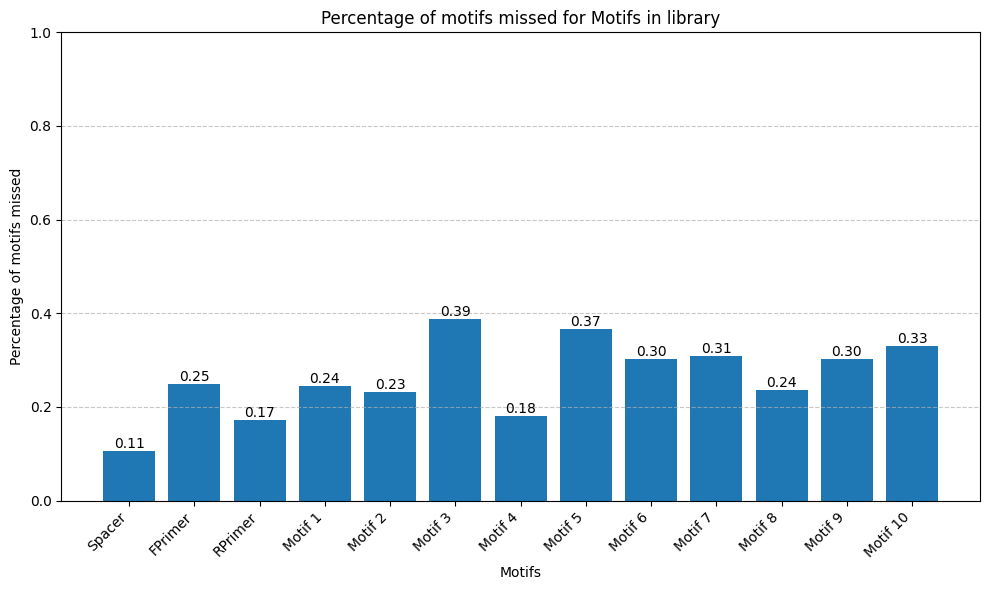

In [34]:
motif_labels = ["Spacer", "FPrimer", "RPrimer"] + [f"Motif {i+1}" for i in range(10)]
missed_counts = motifs_missed
motifs = motif_labels

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(motifs, percentage_motifs_missed)

# Customize the chart
plt.title('Percentage of motifs missed for Motifs in library')
plt.xlabel('Motifs')
plt.ylabel('Percentage of motifs missed')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels if they overlap
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Alignment metric

In [35]:
# So for each read - get the information motifs from the target  
# Similary for the prediction
# See what difference is there -> direct correct prediction or next matches or whatever

counter = 0
for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    print([t for t in i if not (t == 1 or t==2 or t==3)])
    print([t for t in j if not (t == 1 or t==2 or t==3)])
    print()

    if counter == 5:
        break
    counter +=1


[4, 9, 4, 11, 11, 9, 12, 9, 5, 13]
[6, 9, 8, 5, 11, 5, 13, 6, 13, 7, 5]

[4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13]
[4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13, 8]

[11, 8, 5, 12, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9]
[11, 8, 5, 12, 11, 13, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9]

[7, 5, 7, 4, 13, 12]
[5, 7, 4, 13, 12]

[13, 9, 10, 13, 10, 7, 12, 7, 7, 4]
[6, 13, 5, 5, 11, 13, 13, 8, 11, 8, 6, 10, 11, 13, 4]

[5, 7, 7, 9, 13, 5, 7, 13, 4, 7]
[5, 7, 4, 13, 6, 12, 13, 5, 7, 10, 13, 7]



In [36]:
def calculate_error_rates(ground_truth, prediction):
    insertions = 0
    deletions = 0
    substitutions = 0
    
    i, j = 0, 0
    while i < len(ground_truth) and j < len(prediction):
        if ground_truth[i] == prediction[j]:
            i += 1
            j += 1
        elif j + 1 < len(prediction) and ground_truth[i] == prediction[j + 1]:
            # Insertion
            insertions += 1
            j += 1
        elif i + 1 < len(ground_truth) and ground_truth[i + 1] == prediction[j]:
            # Deletion
            deletions += 1
            i += 1
        else:
            # Substitution
            substitutions += 1
            i += 1
            j += 1
    
    # Count remaining insertions or deletions
    insertions += len(prediction) - j
    deletions += len(ground_truth) - i
    
    total_length = len(ground_truth)
    
    return {
        "insertion_rate": insertions / total_length,
        "deletion_rate": deletions / total_length,
        "substitution_rate": substitutions / total_length,
        "total_error_rate": (insertions + deletions + substitutions) / total_length
    }


In [37]:
counter = 0
insertion_rates = []
subsitution_rates = []
deletion_rates = []
total_alignment_error_rates = []
for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    prediction_motifs = [t for t in i if not (t == 1 or t==2 or t==3)]
    target_motifs = [t for t in j if not (t == 1 or t==2 or t==3)]
    
    error_rates = calculate_error_rates(target_motifs, prediction_motifs)

    insertion_rates.append(error_rates['insertion_rate'])
    subsitution_rates.append(error_rates['substitution_rate'])
    deletion_rates.append(error_rates['deletion_rate'])
    total_alignment_error_rates.append(error_rates['total_error_rate'])
 

<BarContainer object of 2 artists>

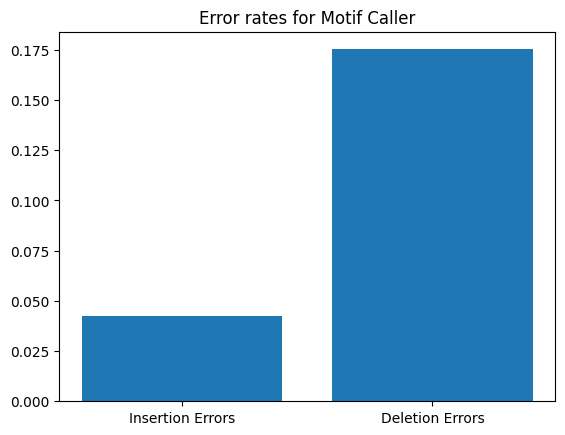

In [38]:
columns = ['Insertion Errors', 'Deletion Errors']
rates = [np.mean(insertion_rates), np.mean(deletion_rates)]
plt.title("Error rates for Motif Caller")
plt.bar(columns, rates)

## Training Curve

In [2]:
log_path = r"C:\Users\Parv\OneDrive\Documents\models\log.txt"
log_text = ""

In [11]:
log_text

['\n',
 'Epoch 0 Batch 0 Loss -6.597797393798828 Transcript: 4Actual Transcript:  2 8 1 6 1 9 1 6 1 5 1 5 1 6 1 9 1 3 2 10 1 5 1 6 1 8 1 9 1 11 1 13 1 4 1 3 2 11 1 11 1 5 1 8 1 13 1 4 1 9 1 4 1Sequence edit distance: 0.9910714285714286Motifs Identified: 0.018867924528301886\n',
 'Epoch 0 Batch 100 Loss 2.552992105484009 Transcript: 11Actual Transcript:  1 13 1 4 1 3 2 13 1 8 1 6 1 10 1 13 1 8 1 4 1 13Sequence edit distance: 1.0Motifs Identified: 0.0\n',
 'Epoch 0 Batch 200 Loss 1.7034454345703125 Transcript: 1Actual Transcript:  12 1 12 1 3 2 13 1 5 1 12 1 9 1 10 1 5 1 5Sequence edit distance: 0.9767441860465116Motifs Identified: 0.05263157894736842\n',
 'Epoch 0 Batch 300 Loss 1.5598423480987549 Transcript: 1Actual Transcript:  13 1 3 2 11 1 6 1 7 1 5 1 13 1 12 1 5 1 5 1 3 2 11 1 5 1Sequence edit distance: 0.9824561403508771Motifs Identified: 0.038461538461538464\n',
 'Epoch 0 Batch 400 Loss 1.9092819690704346 Transcript: 1Actual Transcript:  1 10 1 4 1 8 1 7 1 3 2 6 1 5 1 6 1 9 1 11 

In [3]:
with open(log_path, "r") as f:
    log_text = f.readlines()

In [4]:

epochs = []
batch = []
loss = []
motifs_identified = []
edit_distance = []
for i in log_text:
    if i == '\n':
        continue
    split_line = i.split()
    if len(split_line) > 5:
        epochs.append(split_line[1])
        batch.append(split_line[3])
        loss.append(split_line[5])
        motifs_identified.append(split_line[-1])
        edit_distance.append(split_line[-3])

In [6]:
edit_distance[-3]

'0.8311688311688312Motifs'

In [42]:
edit_distance = [float(i.replace('Motifs', '')) for i in edit_distance if not (i=='Edit' or i =='')]

ValueError: could not convert string to float: ''

In [30]:
loss_ = [loss[i] for i in range(0,len(loss), 30)]

In [31]:
losses = []

for i in loss_:
    try:
        if float(i):
            losses.append(float(i))
    except:
        continue

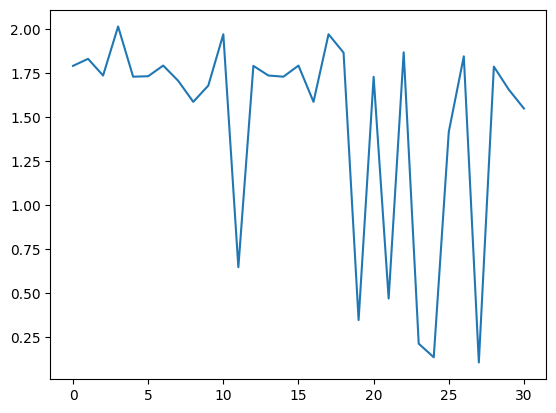

In [61]:
losses_final = losses[8:45]

losses_first_half = losses[8:20]
losses_second_half = [losses_final[i] for i in range(0, len(losses_final), 2)]

# join the two halves
t = losses_first_half + losses_second_half
plt.plot(t)

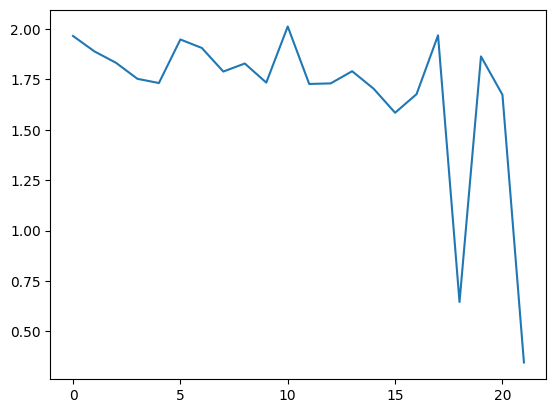

In [41]:
plt.plot(losses[1:23])

In [7]:
validation_losses = [1.75, 1.65, 1.72, 1.70, 1.15, 0.98, 0.87, 0.78, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.79, 0.80, 0.79, 0.80, 0.80, 0.82, 0.84, 0.85, 0.85]

validation_edit_distances = [0.98, 0.98, 0.98, 0.93, 0.54, 0.44, 0.34, 0.33, 0.32, 0.31, 0.31, 0.30, 0.29, 0.29, 0.29, 0.28, 0.28, 0.27, 0.27, 0.26, 0.26, 0.26, 0.25, 0.25]

validation_motifs_identified = [0.04, 0.04, 0.04, 0.08, 0.48, 0.58, 0.69, 0.70, 0.71, 0.72, 0.72, 0.73, 0.74, 0.74, 0.74, 0.75, 0.75, 0.76, 0.75, 0.78, 0.77, 0.77, 0.78, 0.79]

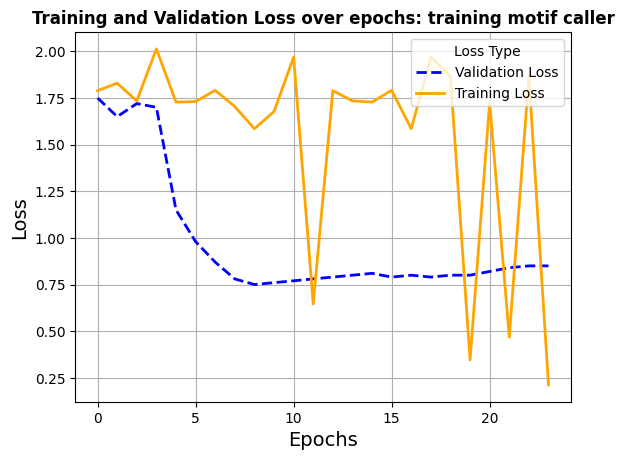

In [72]:
import matplotlib.pyplot as plt

# Plot the data
plt.plot(validation_losses, label='Validation Loss', color='blue', linestyle='--', linewidth=2)
plt.plot(t[:24], label='Training Loss', color='orange', linestyle='-', linewidth=2)

# Add title and labels
plt.title('Training and Validation Loss over epochs: training motif caller', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add grid (optional as 'seaborn-darkgrid' already includes gridlines)
plt.grid(True)

# Add legend with a title and better location
plt.legend(title='Loss Type', loc='upper right', fontsize=10)

# Show the plot
plt.show()


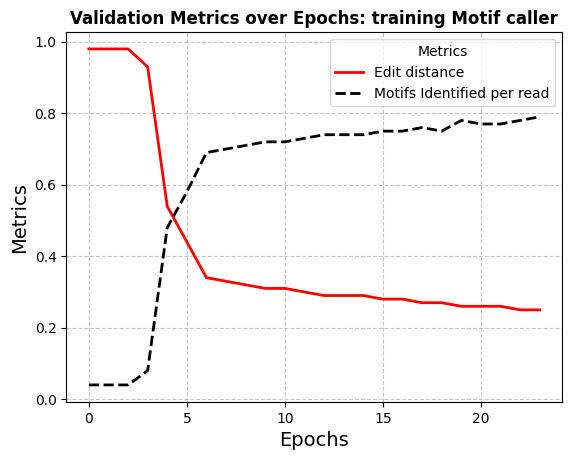

In [79]:
import matplotlib.pyplot as plt

# Plot the data with customization
plt.plot(validation_edit_distances, label='Edit distance', color='red', linestyle='-', linewidth=2)
plt.plot(validation_motifs_identified, label='Motifs Identified per read', color='black', linestyle='--', linewidth=2)

# Add title and labels
plt.title('Validation Metrics over Epochs: training Motif caller', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Metrics', fontsize=14)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend with improved location
plt.legend(title='Metrics', loc='upper right', fontsize=10)

# Show the plot
plt.show()
